In [1]:
# plot_seaice_stats_wrt_longtermmean_forpaper
#
# Steven Cavallo
# January 2024
#######################################
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, datetime, pylab
import pylab as P
from scipy.signal import butter, lfilter, filtfilt
from matplotlib.ticker import FormatStrFormatter


from mstats import *
import utilities_modules as um

In [2]:
fpath_cases = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_bwfilter_3d_10percentile_noshift.dat'
fpath_cases2 = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_meanremoved_3d_10percentile_noshift.dat'
fpath_climo = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_daily_dextent_int_longtermmean_errorbars_1989_2018_3d_noshift.dat'
fpath_climo_monthly = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_monthly_dextent_int_longtermmean_errorbars_1989_2018_3d_noshift.dat'

imagedir = '/Users/scavallo/Documents/scripts/python_scripts/images/'
#imagedir = '/Users/scavallo/Documents/Work/Research/Papers/Nature_geoscience_vRILE/images_working/'

npasses_smooth = 1
label_fontsize = 16
percentiles = [0,100]
figdescript = '5percentile'

labeltext_climo = r'$\Delta$SIE_climatology' # 1981-2010
labeltext_record = r'$\Delta$SIE$_{record}$' # 1979-2018
labeltext_meanplusbw = r'$\Delta$SIE$_{total}$'
labeltext_meanonly = r'$\Delta$SIE$_{mean\,removed}$'
labeltext_bw = r'$\Delta$SIE$_{bwfilt}$'
labeltext_friendly = r'$\Delta$SIE$_{VRILE}$'

month_start_inds = np.array([0,31,60,91,121,152,182,213,244,274,305,335])
ndays_month =      np.array([31,29,31,30,31,30,31,31,30,31,30,31])
month_end_inds = month_start_inds + ndays_month

In [3]:
# read climo
#    Column 1 = month
#    Column 2 = day
#    Column 3 = Extent climatology (no filter)
#    Column 4 = dextent climatology (no filter)
#    Column 5 = Extent climatology (butterworth filter)
#    Column 6 = dextent climatology (butterworth filter)
ab = np.loadtxt(fpath_climo, skiprows=0)       
month_climo = ab[:,0]
day_climo = ab[:,1]
extent_climo = ab[:,2]
dextent_climo = ab[:,3]
dextent_climo_ll = ab[:,4]
dextent_climo_ul = ab[:,5]

del ab
ab = np.loadtxt(fpath_climo_monthly, skiprows=0)       
month_climo_monthly = ab[:,0]
extent_climo_monthly = ab[:,1]
dextent_climo_monthly = ab[:,2]
dextent_climo_monthly_ll_0 = ab[:,3]
dextent_climo_monthly_ul_100 = ab[:,4]
dextent_climo_monthly_ll_1 = ab[:,5]
dextent_climo_monthly_ul_99 = ab[:,6]
dextent_climo_monthly_ll_5 = ab[:,7]
dextent_climo_monthly_ul_95 = ab[:,8]
    

In [4]:
##################
# Read in cases
##################
# First case
print(fpath_cases)
aa = np.loadtxt(fpath_cases, skiprows=0)       
datelist = aa[:,0]
dextent = aa[:,1]
dextent_nofilt = aa[:,2]

years_start = []
months_start = []
days_start = []
mmdd_start = []
dextent_anom = []
ncases = np.size(datelist)
print(ncases)
tt = 0
while tt < ncases:

    datestrinit = str(datelist[tt])	
    yyyy = datestrinit[0:4]
    mm = datestrinit[4:6]
    dd = datestrinit[6:8]
    hh = datestrinit[8:10]
    mmdd = datestrinit[4:8]
    
    years_start.append(yyyy)
    months_start.append(mm)
    days_start.append(dd)
    mmdd_start.append(mmdd)
          
    tt += 1

dextent_anom = np.array(dextent_anom).astype(float)

# Next Case
print(fpath_cases2)
aa = np.loadtxt(fpath_cases2, skiprows=0)       
datelist_case2 = aa[:,0]
dextent_case2 = aa[:,1]
dextent_nofilt_case2 = aa[:,2]

years_start_case2 = []
months_start_case2 = []
days_start_case2 = []
mmdd_start_case2 = []
dextent_anom_case2 = []
ncases_case2 = np.size(datelist_case2)
print(ncases_case2)
tt = 0
while tt < ncases_case2:

    datestrinit = str(datelist_case2[tt])	
    yyyy = datestrinit[0:4]
    mm = datestrinit[4:6]
    dd = datestrinit[6:8]
    hh = datestrinit[8:10]
    mmdd = datestrinit[4:8]
    
    years_start_case2.append(yyyy)
    months_start_case2.append(mm)
    days_start_case2.append(dd)
    mmdd_start_case2.append(mmdd)
    
       
    tt += 1

dextent_anom_case2 = np.array(dextent_anom_case2,dtype='object')

/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_bwfilter_3d_10percentile_noshift.dat
560
/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/rapid_seaice_loss_events_int_withboth_annual_meanremoved_3d_10percentile_noshift.dat
507


In [5]:
# Climatology
dextent_months_climo = np.zeros(len(ndays_month))
dextent_months_climo_ul = np.zeros(len(ndays_month))
dextent_months_climo_ll = np.zeros(len(ndays_month))
ul = percentiles[0]
ll = percentiles[1]
for tt in range(1,13):
    last_day = ndays_month[tt-1]
    #[inds3] = np.where(month_climo == tt)
    [inds3] = np.where( (month_climo == tt) & (day_climo != 1) & (day_climo != 2) & (day_climo != last_day) )
    dextent_months_climo[tt-1] = np.nanmean(dextent_climo[inds3])
    dextent_months_climo_ll[tt-1] = np.nanmin(dextent_climo_ll[inds3]) #np.nanpercentile(dextent_climo[inds3], ll)
    dextent_months_climo_ul[tt-1] = np.nanmax(dextent_climo_ul[inds3])#np.nanpercentile(dextent_climo[inds3], ul)


In [6]:
# Case 1
years_plot = np.array(years_start)
months_plot = np.array(months_start).astype(int)
days_plot = np.array(days_start)
mmdd_plot = np.array(mmdd_start)

dextent_months = np.zeros(len(ndays_month))
dextent_months_nofilt = np.zeros(len(ndays_month))
dextent_months_nofilt_ul = np.zeros(len(ndays_month))
dextent_months_nofilt_ll = np.zeros(len(ndays_month))
dextent_months_ul = np.zeros(len(ndays_month))
dextent_months_ll = np.zeros(len(ndays_month))
ul = percentiles[0]
ll = percentiles[1]
for tt in range(1,13):
    [inds3] = np.where(months_plot == tt)
    dextent_months[tt-1] = np.nanmean(dextent[inds3])
    dextent_months_nofilt[tt-1] = np.nanmean(dextent_nofilt[inds3])
 
    dextent_months_ll[tt-1] = np.nanpercentile(dextent[inds3], ll)
    dextent_months_ul[tt-1] = np.nanpercentile(dextent[inds3], ul)  
    dextent_months_nofilt_ll[tt-1] = np.nanpercentile(dextent_nofilt[inds3], ll)
    dextent_months_nofilt_ul[tt-1] = np.nanpercentile(dextent_nofilt[inds3], ul)      
    

In [7]:
# Case 2
years_plot_case2 = np.array(years_start_case2)
months_plot_case2 = np.array(months_start_case2).astype(int)
days_plot_case2 = np.array(days_start_case2)
mmdd_plot_case2 = np.array(mmdd_start_case2)

dextent_months_case2 = np.zeros(len(ndays_month))
dextent_months_nofilt_case2 = np.zeros(len(ndays_month))
dextent_months_nofilt_ul_case2 = np.zeros(len(ndays_month))
dextent_months_nofilt_ll_case2 = np.zeros(len(ndays_month))
dextent_months_ul_case2 = np.zeros(len(ndays_month))
dextent_months_ll_case2 = np.zeros(len(ndays_month))
ul = percentiles[0]
ll = percentiles[1]
for tt in range(1,13):
    [inds3] = np.where(months_plot_case2 == tt)
    dextent_months_case2[tt-1] = np.nanmean(dextent_case2[inds3])
    dextent_months_nofilt_case2[tt-1] = np.nanmean(dextent_nofilt_case2[inds3])
 
    dextent_months_ll_case2[tt-1] = np.nanpercentile(dextent_case2[inds3], ll)
    dextent_months_ul_case2[tt-1] = np.nanpercentile(dextent_case2[inds3], ul)   
    dextent_months_nofilt_ll_case2[tt-1] = np.nanpercentile(dextent_nofilt_case2[inds3], ll)
    dextent_months_nofilt_ul_case2[tt-1] = np.nanpercentile(dextent_nofilt_case2[inds3], ul)       

In [8]:
# Make errorbars
upper_err = dextent_months_ul - dextent_months
lower_err = dextent_months - dextent_months_ll
upper_err_anom = dextent_climo_monthly_ul_100   - dextent_climo_monthly 
lower_err_anom = dextent_climo_monthly - dextent_climo_monthly_ll_0 

upper_err_climo = dextent_months_climo_ul - dextent_months_climo
lower_err_climo = dextent_months_climo - dextent_months_climo_ll

upper_err_nofilt = dextent_months_nofilt_ul - dextent_months_nofilt
lower_err_nofilt = dextent_months_nofilt - dextent_months_nofilt_ll
upper_err_nofilt_case2 = dextent_months_nofilt_ul_case2 - dextent_months_nofilt_case2
lower_err_nofilt_case2 = dextent_months_nofilt_case2 - dextent_months_nofilt_ll_case2



In [9]:
[minds] = np.where( (months_plot==6) | (months_plot==7)| (months_plot==8))
years_jja = years_plot[minds]
month_list =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

alphaval = 0.75
normval = 0
leg_loc = 'upper right'

yearbins = np.arange(1979,2016,1)
monthbins = np.arange(1,13.5,1)

yerr_climo = np.abs(np.array([lower_err_anom,upper_err_anom]))
yerr_case2 = np.abs(np.array([lower_err_nofilt_case2, upper_err_nofilt_case2]))
yerr_nofilt = np.abs(np.array([lower_err_nofilt,upper_err_nofilt]))


golden = (pylab.sqrt(5)+1.)/2.
figprops = dict(figsize=(8., 8./ golden ), dpi=128)    
adjustprops = dict(left=0.15, bottom=0.1, right=0.90, top=0.93, wspace=0.2, hspace=0.2) 

/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_15867/1753099117.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(binvals-binshift, dextent_climo_monthly,yerr=yerr_climo, fmt='ko',ecolor='0.33', elinewidth=elinew,marker='o',markerfacecolor='0.5',markeredgewidth=2,markeredgecolor='k')
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_15867/1753099117.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(binvals-binshift, dextent_months_nofilt_case2,yerr=yerr_case2, fmt='ko',ecolor='r', elinewidth=elinew,marker='o',markerfacecolor='r',markeredgewidth=2,markeredgecolor='k')
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_15867/1753099117.py:29: UserWarning: marker is redundantly defined by the 'marker'

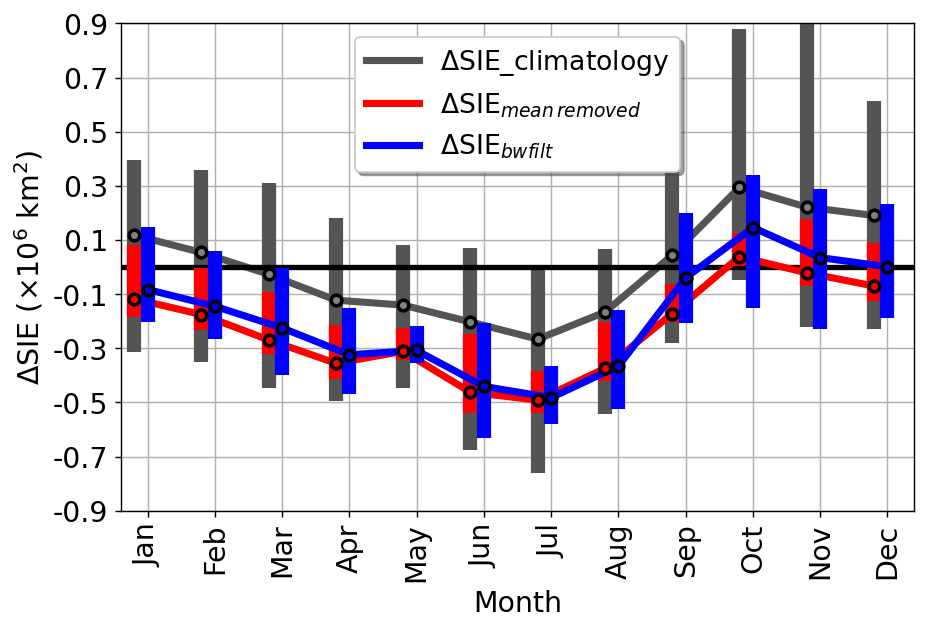

In [10]:
binvals = np.arange(1,13)
bincenters = np.zeros(len(binvals))
bincenters[0:-1] = 0.5*(binvals[1:]+binvals[:-1])
bincenters[-1] = bincenters[-2]+1.0

yticks1 = np.arange(-0.9,1.0,0.1)
[ytind] = np.where(np.abs(yticks1)<0.001)
yticks1[ytind] = 0.0
yticks2 = yticks1

fig = plt.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)

binshift = 0.2
rotang = 90
elinew = 8
z0 = np.zeros_like(binvals).astype('f')


#p0, = ax1.plot(binvals-binshift, dextent_months_climo,'0.33',linewidth=4.0,label=labeltext_climo)
#ax1.errorbar(binvals-binshift, dextent_months_climo,yerr=yerr_climo, fmt='ko',ecolor='0.33', elinewidth=elinew,marker='o',markerfacecolor='0.5',markeredgewidth=2,markeredgecolor='k')    
p0, = ax1.plot(binvals-binshift, dextent_climo_monthly,'0.33',linewidth=4.0,label=labeltext_climo)
ax1.errorbar(binvals-binshift, dextent_climo_monthly,yerr=yerr_climo, fmt='ko',ecolor='0.33', elinewidth=elinew,marker='o',markerfacecolor='0.5',markeredgewidth=2,markeredgecolor='k')    
plt.axhline(linewidth=3, color='k')

p1b, = ax1.plot(binvals-binshift, dextent_months_nofilt_case2,'r-',linewidth=4.0,label=labeltext_meanonly)
ax1.errorbar(binvals-binshift, dextent_months_nofilt_case2,yerr=yerr_case2, fmt='ko',ecolor='r', elinewidth=elinew,marker='o',markerfacecolor='r',markeredgewidth=2,markeredgecolor='k')    
p1a, = ax1.plot(binvals, dextent_months_nofilt,'b-',linewidth=4.0,label=labeltext_bw)
ax1.errorbar(binvals, dextent_months_nofilt,yerr=yerr_nofilt, fmt='ko',ecolor='b', elinewidth=elinew,marker='o',markerfacecolor='b',markeredgewidth=2,markeredgecolor='k')

ax1.grid(True, linestyle='-')
legend = ax1.legend(loc='upper center', shadow=True, fontsize=label_fontsize-1)
#plt.title(titletext1,fontsize=label_fontsize)
#um.label_options(ax1,fontsize=label_fontsize,xaxis_opt=False,yaxis_opt=True,bold_opt=False)

ax1.set_xticks(binvals)
ax1.set_xticklabels(month_list,rotation=rotang,fontsize=label_fontsize)

ax1.set_yticks(yticks1[::2])
ax1.set_yticklabels((yticks1[::2]),fontsize=label_fontsize)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax2.set_yticks(yticks2)
#ax2.set_yticklabels(yticks2)

plt.xlim([binvals[0]-(2*binshift),binvals[-1]+(2*binshift)])
plt.ylim([yticks1[0],yticks1[-1]])

ax1.set_ylabel(r'$\Delta$SIE ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
figname_suffix = 'values'
ax1.set_xlabel('Month',fontsize=label_fontsize)
save_name = 'seaiceloss_' + figdescript + '_dextents_withclimo_errorbars2_' + figname_suffix + '.png'
plt.savefig(imagedir + save_name, bbox_inches='tight')
plt.show()